# Imports and loading

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from loads import *

PATH_FOLDER = "MovieSummaries/"

In [3]:
# Loading character metadata DataFrame
character_df = load_character_metadata()
# Loading movie metadata DataFrame
movie_df = load_movie_metadata()
# Loading plot summaries DataFrame
plot_summaries_df = load_plot_summaries()
# Loading TVTropes DataFrame
tvtropes_df = load_tvtropes()
# Loading name clusters DataFrame
name_clusters_df = load_name_clusters()
# Loading inflation DataFrame
inflation = pd.read_excel("external_dataset/inflation.xlsx", header=11)

C:\Users\ratas\.conda\envs\ada\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


# Preprocessing

## CLEANING

#### MOVIE METADATA

Extract variables from (ID : variable) tuples

In [4]:
movie_df['Movie Languages'] = movie_df['Movie languages (Freebase ID:name tuples)'].apply(lambda x: list(json.loads(x).values()))
movie_df['Movie Countries'] = movie_df['Movie countries (Freebase ID:name tuples)'].apply(lambda x: list(json.loads(x).values()))
movie_df['Movie Genres'] = movie_df['Movie genres (Freebase ID:name tuples)'].apply(lambda x: list(json.loads(x).values()))

Drop useless columns (IDs)

In [5]:
# movie_columns_to_drop = ['Movie languages (Freebase ID:name tuples)', 'Movie countries (Freebase ID:name tuples)','Movie genres (Freebase ID:name tuples)','Freebase movie ID']
# movie_df.drop(movie_columns_to_drop, axis=1, inplace=True)
movie_df.shape

(81741, 12)

Drop movies with missing (Nan) Box office revenue since it's our main interest

In [6]:
movie_df.dropna(subset=['Movie box office revenue'], inplace=True)
movie_df.shape

(8401, 12)

Extracting Year and Month from the Movie release date (date format YYYY and YYYY-MM-DD can't be dealt together)

In [7]:
movie_df.dropna(subset=["Movie release date"], inplace=True)
movie_df['Year'] = movie_df["Movie release date"].apply(lambda x: str(x)[:4]).astype(int)
movie_df['Month'] = pd.to_datetime(movie_df['Movie release date'],errors='coerce').dt.month
movie_df.shape

(8328, 14)

#### Inflation

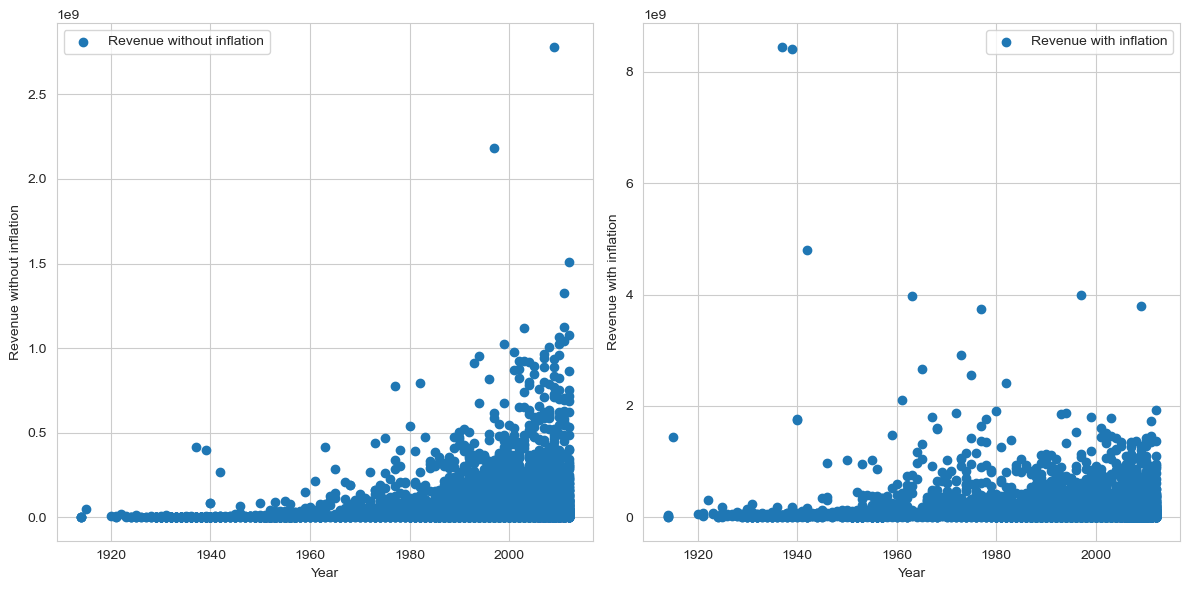

In [43]:
inflation["Cumulative Inflation to 2022"] = inflation.iloc[-1].Annual / inflation["Annual"]
movie_with_inflation = pd.merge(movie_df, inflation.drop(['Annual'], axis=1), on='Year')
movie_with_inflation['Revenue with inflation'] = movie_with_inflation['Movie box office revenue'] * movie_with_inflation['Cumulative Inflation to 2022']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot for Revenue without inflation
ax1.scatter(movie_with_inflation['Year'], movie_with_inflation['Movie box office revenue'], label='Revenue without inflation')
ax1.set_xlabel('Year')
ax1.set_ylabel('Revenue without inflation')
ax1.legend()

# Plot for Revenue with inflation
ax2.scatter(movie_with_inflation['Year'], movie_with_inflation['Revenue with inflation'], label='Revenue with inflation')
ax2.set_xlabel('Year')
ax2.set_ylabel('Revenue with inflation')
ax2.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [44]:
# top5 movies with highest revenue with inflation
movie_with_inflation.sort_values(by=['Revenue with inflation'], ascending=False).head(5)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),Movie Languages,Movie Countries,Movie Genres,Year,Month,Cumulative Inflation to 2022,Revenue with inflation
8254,76361,/m/0k4d7,Snow White and the Seven Dwarfs,1937-12-21,4.160000e+08,84.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02l7c8"": ""Romance Film"", ""/m/04t36"": ""Mus...",[English Language],[United States of America],"[Romance Film, Musical, Fantasy, Family Film, ...",1937,12.0,20.323264,8.454478e+09
8067,2804704,/m/083skw,Gone with the Wind,1939-12-15,4.000000e+08,234.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/060__y"": ""Film adaptation"", ""/m/04xvh5"": ...",[English Language],[United States of America],"[Film adaptation, Costume drama, Roadshow thea...",1939,12.0,21.054317,8.421727e+09
7514,683122,/m/04j1zjw,Bambi,1942-08-08,2.674472e+08,69.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03k9fj"": ""Adventure"", ""/m/0hj3myq"": ""Chil...",[English Language],[United States of America],"[Adventure, Children's/Family, Animation, Comi...",1942,8.0,17.954294,4.801825e+09
3726,52371,/m/0dr_4,Titanic,1997-11-01,2.185372e+09,194.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America""}","{""/m/0fx2s"": ""Tragedy"", ""/m/04xvh5"": ""Costume ...","[Italian Language, English Language, French La...",[United States of America],"[Tragedy, Costume drama, Historical fiction, A...",1997,11.0,1.823396,3.984798e+09
7756,210224,/m/01dvps,Love with the Proper Stranger,1963-12-25,4.150049e+08,121.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06lbpz"": ""Social problem film"", ""/m/01t_v...",[English Language],[United States of America],"[Social problem film, Comedy-drama, Black-and-...",1963,12.0,9.563889,3.969061e+09


In [45]:
# top5 movies with highest revenue without inflation
movie_with_inflation.sort_values(by=['Movie box office revenue'], ascending=False).head(5)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),Movie Languages,Movie Countries,Movie Genres,Year,Month,Cumulative Inflation to 2022,Revenue with inflation
1962,4273140,/m/0bth54,Avatar,2009-12-10,2.782275e+09,178.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","[English Language, Spanish Language]","[United States of America, United Kingdom]","[Thriller, Science Fiction, Adventure, Compute...",2009,12.0,1.364124,3.795367e+09
3726,52371,/m/0dr_4,Titanic,1997-11-01,2.185372e+09,194.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America""}","{""/m/0fx2s"": ""Tragedy"", ""/m/04xvh5"": ""Costume ...","[Italian Language, English Language, French La...",[United States of America],"[Tragedy, Costume drama, Historical fiction, A...",1997,11.0,1.823396,3.984798e+09
6921,22114132,/m/062zm5h,The Avengers,2012-04-11,1.511758e+09,137.0,"{""/m/06b_j"": ""Russian Language"", ""/m/02h40lc"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ...","[Russian Language, English Language]",[United States of America],"[Science Fiction, Action]",2012,4.0,1.274663,1.926982e+09
6080,31941988,/m/0gvsynb,Harry Potter and the Deathly Hallows – Part 2,2011-07-07,1.328111e+09,130.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/07s9rl0"": ""Drama"", ""/m/02n4kr"": ""Mystery""...",[English Language],"[United States of America, United Kingdom]","[Drama, Mystery, Fantasy, Adventure]",2011,7.0,1.301042,1.727928e+09
6025,25001260,/m/0872p_c,Transformers: Dark of the Moon,2011-06-23,1.123747e+09,157.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mt0"": ""Alien Film"", ""/m/06n90"": ""Scie...",[English Language],[United States of America],"[Alien Film, Science Fiction, Action, Adventure]",2011,6.0,1.301042,1.462042e+09


#### CHARACTER METADATA

Drop useless columns (IDs and actor height)

In [9]:
character_columns_to_drop = ['Freebase movie ID', 'Actor ethnicity (Freebase ID)','Freebase character ID','Freebase actor ID','Actor height (in meters)']
character_df.drop(character_columns_to_drop, axis=1, inplace=True)

## Splitting

Split the movie dataframe in many small different df for each feature. Each small df has one feature and 'Movie Box office revenue'

In [10]:
movie_runtime_df = movie_df[['Movie runtime', 'Movie box office revenue']].copy()
movie_languages_df = movie_df[['Movie Languages', 'Movie box office revenue']].copy()
movie_countries_df = movie_df[['Movie Countries', 'Movie box office revenue']].copy()
movie_genres_df = movie_df[['Movie Genres', 'Movie box office revenue']].copy()
movie_release_date_df = movie_df[['Movie release date', 'Movie box office revenue']].copy()

Drop movies in each small dataframe, only for the missing values (Nan) of the concerned feature

In [11]:
movie_runtime_df.dropna(subset=['Movie runtime'], inplace=True)
movie_languages_df.dropna(subset=['Movie Languages'], inplace=True)
movie_countries_df.dropna(subset=['Movie Countries'], inplace=True)
movie_genres_df.dropna(subset=['Movie Genres'], inplace=True)
movie_release_date_df.dropna(subset=["Movie release date"], inplace=True)

Extracting Year and Month from the Movie release date (date format YYYY and YYYY-MM-DD can't be dealt together)

In [12]:
movie_release_date_df['Year'] = movie_release_date_df["Movie release date"].apply(lambda x: str(x)[:4]).astype(int)
movie_release_date_df['Month'] = pd.to_datetime(movie_release_date_df['Movie release date'],errors='coerce').dt.month

New Year and Month feature df & erases nans

In [13]:
years_df = movie_release_date_df[['Year','Movie box office revenue']].copy()
months_df = movie_release_date_df[['Month','Movie box office revenue']].copy()
years_df.dropna(subset=['Year'], inplace=True) #no nan but safer
months_df.dropna(subset=['Month'], inplace=True)

je merge characters et movie

In [14]:
character_movie_merged_df = pd.merge(character_df.drop(['Movie release date'],axis=1), movie_with_inflation, on=['Wikipedia movie ID'])


In [15]:
character_movie_merged_df.head()

,Wikipedia movie ID,Character name,Actor date of birth,Actor gender,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase movie ID,Movie name,Movie release date,...,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),Movie Languages,Movie Countries,Movie Genres,Year,Month,Cumulative Inflation to 2022,Revenue with inflation
0,975900,Akooshay,1958-08-26,F,Wanda De Jesus,42.0,/m/0bgchxw,/m/03vyhn,Ghosts of Mars,2001-08-24,...,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,8.0,1.652484,2.315268e+07
1,975900,Lieutenant Melanie Ballard,1974-08-15,F,Natasha Henstridge,27.0,/m/0jys3m,/m/03vyhn,Ghosts of Mars,2001-08-24,...,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,8.0,1.652484,2.315268e+07
2,975900,Desolation Williams,1969-06-15,M,Ice Cube,32.0,/m/0jys3g,/m/03vyhn,Ghosts of Mars,2001-08-24,...,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,8.0,1.652484,2.315268e+07
3,975900,Sgt Jericho Butler,1967-09-12,M,Jason Statham,33.0,/m/02vchl6,/m/03vyhn,Ghosts of Mars,2001-08-24,...,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,8.0,1.652484,2.315268e+07
4,975900,Bashira Kincaid,1977-09-25,F,Clea DuVall,23.0,/m/02vbb3r,/m/03vyhn,Ghosts of Mars,2001-08-24,...,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,8.0,1.652484,2.315268e+07


je split sur gender et pour ce faire je prends d'abord avec l'acteur pour drop les vrai duplicates

In [16]:
actor_gender_df = character_movie_merged_df[['Actor gender','Actor name','Movie box office revenue']].copy()
actor_gender_df.drop_duplicates()
gender_df = actor_gender_df[['Actor gender','Movie box office revenue']].copy()
gender_df.dropna(subset=['Actor gender'], inplace=True)

In [17]:
actor_df = character_movie_merged_df[['Actor name','Actor age at movie release','Movie box office revenue']].copy()
actor_df.dropna()

,Actor name,Actor age at movie release,Movie box office revenue
0,Wanda De Jesus,42.0,14010832.0
1,Natasha Henstridge,27.0,14010832.0
2,Ice Cube,32.0,14010832.0
3,Jason Statham,33.0,14010832.0
4,Clea DuVall,23.0,14010832.0
...,...,...,...
100848,Roland Culver,64.0,5400000.0
100849,Michael Hordern,53.0,5400000.0
100850,Reginald Beckwith,56.0,5400000.0
100851,Gong Yoo,32.0,30723856.0


# ANALYSIS

In [26]:
analysis_df = movie_with_inflation[['Revenue with inflation', 'Year', 'Month']].copy()
analysis_df

,Revenue with inflation,Year,Month
0,2.315268e+07,2001,8.0
1,4.855272e+07,2001,6.0
2,7.559723e+06,2001,8.0
3,1.176346e+08,2001,2.0
4,2.331158e+08,2001,11.0
...,...,...,...
8321,8.557164e+07,1928,8.0
8322,2.344663e+07,1928,12.0
8323,4.278582e+07,1928,3.0
8324,2.909436e+07,1928,4.0


In [47]:
analysis_df.dropna(inplace=True)
dummy_variables = pd.get_dummies(analysis_df, columns=['Year'], prefix=['Year'])
dummy_variables

,Revenue with inflation,Month,Year_1914,Year_1921,Year_1922,Year_1924,Year_1925,Year_1926,Year_1928,Year_1929,...,Year_2003,Year_2004,Year_2005,Year_2006,Year_2007,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012
0,2.315268e+07,8.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,4.855272e+07,6.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,7.559723e+06,8.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1.176346e+08,2.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2.331158e+08,11.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8321,8.557164e+07,8.0,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
8322,2.344663e+07,12.0,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
8323,4.278582e+07,3.0,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
8324,2.909436e+07,4.0,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [49]:
import statsmodels.api as sm

X = dummy_variables.drop(['Revenue with inflation', 'Month'], axis=1)
y = dummy_variables['Revenue with inflation']

X = X.astype(int)

X = sm.add_constant(X)


model = sm.OLS(y, X).fit()

print(model.summary())


                              OLS Regression Results                              
Dep. Variable:     Revenue with inflation   R-squared:                       0.052
Model:                                OLS   Adj. R-squared:                  0.039
Method:                     Least Squares   F-statistic:                     4.057
Date:                    Fri, 17 Nov 2023   Prob (F-statistic):           1.30e-33
Time:                            19:10:35   Log-Likelihood:            -1.4150e+05
No. Observations:                    6792   AIC:                         2.832e+05
Df Residuals:                        6701   BIC:                         2.838e+05
Df Model:                              90                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       